In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import json
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.utils import preprocess_text, prepare_labels, generate_batches, target_integers, encode_decode_target
from src.preprocessor import DatasetModel, PredictorVectorizer, Vocabulary, SequenceVocabulary
from src.models import GramsClassifier, ContentClassifier
from src.metrics import calc_jaccard
from src.settings import logreg_params

import warnings
warnings.filterwarnings('ignore')

ImportError: cannot import name 'logreg_params' from 'src.settings' (C:\Users\anato\ML projects\happy-dating\src\settings.py)

In [3]:
train_df = pd.read_csv('../coleridgeinitiative-show-us-the-data/train.csv')
train_files_path = '../coleridgeinitiative-show-us-the-data/train'
test_files_path = '../coleridgeinitiative-show-us-the-data/test'

# 0. Подготовка текста

In [4]:
# добавление json в csv
def read_append_return(filename, train_files_path=train_files_path, output='text', keep_list=False):
    json_path = os.path.join(train_files_path, (filename + '.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))

    if not keep_list:
        headings = ' '.join(headings)
        contents = ' '.join(contents)
        combined = '\n\n '.join(combined)

    if output == 'text':
        return contents
    elif output == 'head':
        return headings
    else:
        return combined

In [5]:
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


In [6]:
train_df['text'] = train_df['Id'].apply(read_append_return) # загружаем текст статей

In [8]:
train_df['cleaned_label_test'] = prepare_labels(data=train_df)

In [9]:
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)

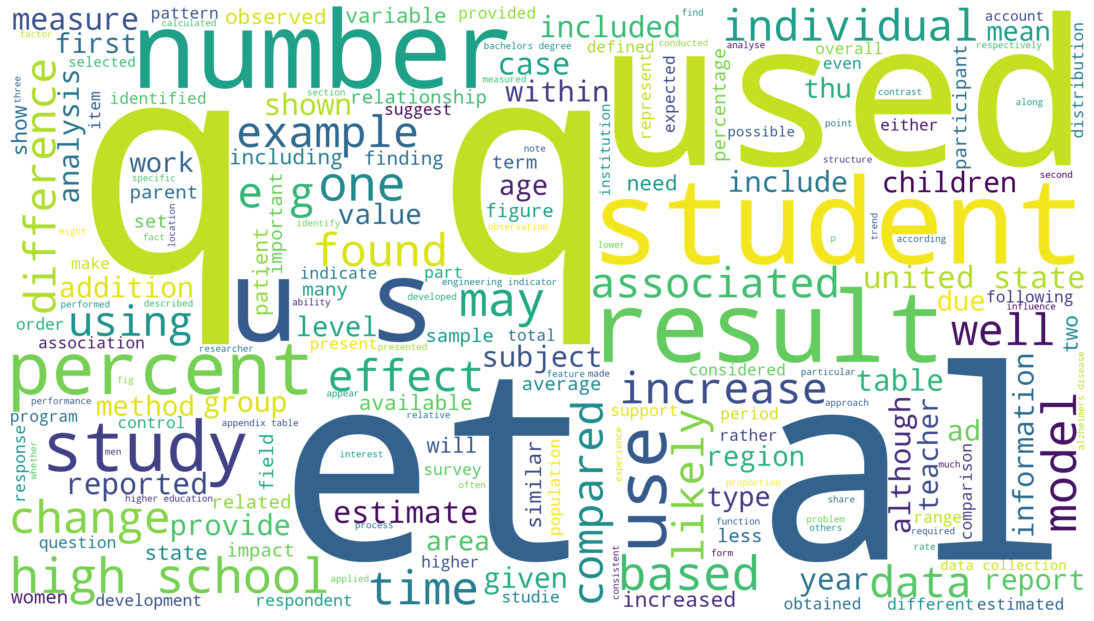

In [10]:
text = ' '.join(train_df['cleaned_text'].sample(frac=0.3))
wordcloud = WordCloud(background_color='white', width=2560, height=1440).generate(text)

barplot_dim = (15, 15)
ax = plt.subplots(figsize=barplot_dim, facecolor='w')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [11]:
train_df['cleaned_label_test'].nunique()

378

In [12]:
train_df['cleaned_text'].apply(lambda x: len(x.split())).describe()

count    1.966100e+04
mean     8.340936e+03
std      2.548595e+04
min      6.300000e+01
25%      3.571000e+03
50%      5.125000e+03
75%      7.502000e+03
max      1.658494e+06
Name: cleaned_text, dtype: float64

In [13]:
train_df.drop(['dataset_title', 'dataset_label', 'cleaned_label', 'text'], axis=1, inplace=True)

In [14]:
train_df['pub_title'].apply(lambda x: len(x.split())).describe()

count    19661.000000
mean        12.912009
std          4.701127
min          1.000000
25%         10.000000
50%         12.000000
75%         16.000000
max         84.000000
Name: pub_title, dtype: float64

In [15]:
train_df['pub_title'] = [x.lower() for x in train_df['pub_title']]

# 1. Бэйзлайн

Попробуем для начала сматчить по названию статьи. Воспользуемся TF-Idf, N_grams и логистической регрессией.

In [163]:
X = train_df['pub_title']
y = train_df['cleaned_label_test']

In [164]:
targets, integers = target_integers(data=y)
y = encode_decode_target(data=y, targets=targets, integers=integers, encode=True)

In [165]:
X_train, x_valid, Y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=43)

In [199]:
baseline = GramsClassifier(model=LogisticRegression(**logreg_params))
baseline.fit(list(X_train), list(Y_train))

In [200]:
predictions = baseline.predict(list(x_valid))
predictions

array([[4.21248986e-02, 4.93752572e-03, 1.12321602e-03, ...,
        6.82403878e-05, 1.36312364e-04, 1.35960784e-04],
       [4.35661534e-03, 1.90297030e-03, 6.53473506e-04, ...,
        4.75791287e-05, 9.37989726e-05, 9.35632954e-05],
       [7.22058630e-03, 2.09029448e-03, 6.27047647e-04, ...,
        4.25631649e-05, 8.43480384e-05, 8.41331341e-05],
       ...,
       [2.04003526e-02, 3.69805803e-03, 9.72132050e-04, ...,
        6.75080653e-05, 1.33545897e-04, 1.33206420e-04],
       [4.21248986e-02, 4.93752572e-03, 1.12321602e-03, ...,
        6.82403878e-05, 1.36312364e-04, 1.35960784e-04],
       [2.33696498e-02, 4.36504774e-03, 8.72245835e-04, ...,
        5.56751047e-05, 1.10833718e-04, 1.10549967e-04]])

In [201]:
classes = []
for pred in predictions:
    classes.append(np.argmax(pred))

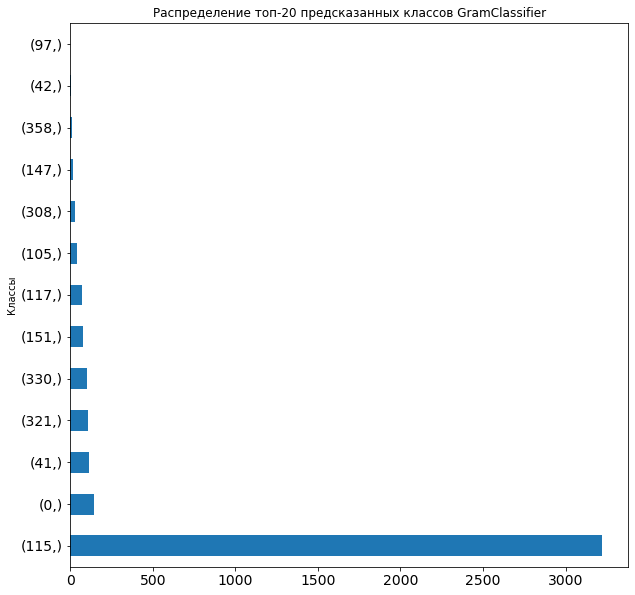

In [202]:
pd.DataFrame(classes).value_counts()[:20].plot(kind='barh', figsize=(10,10), 
                                              title='Распределение топ-20 предсказанных классов GramClassifier',
                                              fontsize=14, xlabel='Классы', ylabel='Частота');

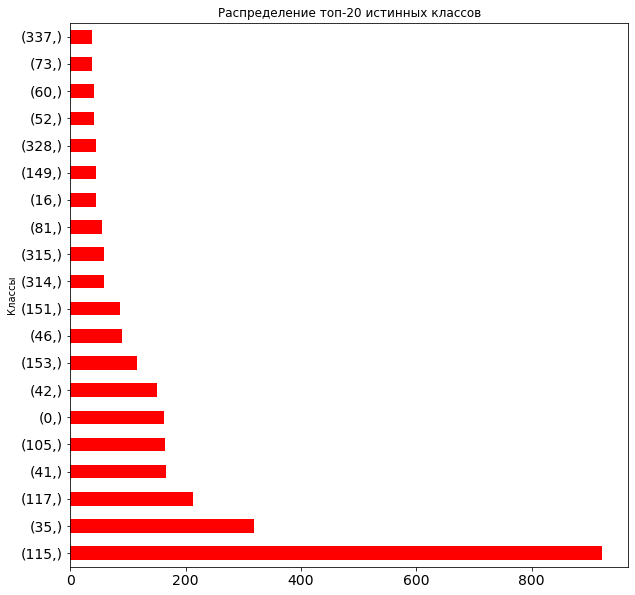

In [172]:
pd.DataFrame(y_valid).value_counts()[:20].plot(kind='barh', figsize=(10,10), 
                                              title='Распределение топ-20 истинных классов',
                                              fontsize=14, xlabel='Классы', ylabel='Частота',
                                              color='r');

In [203]:
text_test_preds = encode_decode_target(data=pd.Series(classes), targets=targets, integers=integers, encode=False)

In [210]:
text_test_true = encode_decode_target(data=y_valid, targets=targets, integers=integers, encode=False)

In [212]:
print(calc_jaccard(str(text_test_true), str(text_test_preds)))

0.20408163265306123


# 2. Реккурентная нейросеть

На каждом временном шаге RNN вычисляет вектор скрытого состояния на основе вектора скрытого состояния предыдущего шага и входного
вектора текущего шага. 
- В классической RNN мы **каждый раз обновляем вектор скрытого состояния**, независимо от того, имело ли это смысл.
В результате, каждый раз именно входные данные определяют то, что будет хранится в векторе скрытого состояния. Это порождает
проблему долгосрочного запоминания. 
- Другая проблема - **склонность выхода градиентов из под контроля**, иными словами, очень 
быстрый или медленный рост градиента способен вызвать нестабильное обучение. С этим можно бороться, например, при помощи
RELU, обрезания градиентов либо **шлюзования**. Шлюзование определяет то, какая чать величины вектора скрытого состояния
сохранится, а какая не сохранится. Обычно в качестве шлюзовой функции выступает **сигмоида**.
В случае с **LSTM**, сигмоида домножается ещё на одну функцию активации для умышленного "забывания" значений предыдущего скрытого состояния. В случае с **GRU**